In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import os
import json

import bokeh
import geopandas

pd.options.display.max_colwidth=200
%matplotlib inline

In [2]:
# data directory
data_dir = "../data"
raw_data = os.path.join(data_dir, "raw")

In [3]:
df = pd.read_csv(os.path.join(raw_data, "summary_listings.csv"))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48864 entries, 0 to 48863
Data columns (total 16 columns):
id                                48864 non-null int64
name                              48848 non-null object
host_id                           48864 non-null int64
host_name                         48846 non-null object
neighbourhood_group               48864 non-null object
neighbourhood                     48864 non-null object
latitude                          48864 non-null float64
longitude                         48864 non-null float64
room_type                         48864 non-null object
price                             48864 non-null int64
minimum_nights                    48864 non-null int64
number_of_reviews                 48864 non-null int64
last_review                       38733 non-null object
reviews_per_month                 38733 non-null float64
calculated_host_listings_count    48864 non-null int64
availability_365                  48864 non-null int64

## Subset the dataset based on neighbourhood_group and room_type

In [7]:
df.neighbourhood_group.value_counts()

Manhattan        21456
Brooklyn         20114
Queens            5811
Bronx             1105
Staten Island      378
Name: neighbourhood_group, dtype: int64

In [8]:
df.room_type.value_counts()

Entire home/apt    25296
Private room       22397
Shared room         1171
Name: room_type, dtype: int64

In [14]:
df.groupby(['neighbourhood_group', 'room_type'])['price'].count()

neighbourhood_group  room_type      
Bronx                Entire home/apt      378
                     Private room         659
                     Shared room           68
Brooklyn             Entire home/apt     9565
                     Private room       10131
                     Shared room          418
Manhattan            Entire home/apt    13054
                     Private room        7931
                     Shared room          471
Queens               Entire home/apt     2118
                     Private room        3489
                     Shared room          204
Staten Island        Entire home/apt      181
                     Private room         187
                     Shared room           10
Name: price, dtype: int64

In [23]:
df = df[(df.neighbourhood_group == 'Manhattan') & (df.room_type == 'Entire home/apt')]
df.shape

(13054, 16)

## Construct a geopandas dataframe

In [24]:
geo_df = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))

In [25]:
# filter 
cols = ['price', 'neighbourhood', 'neighbourhood_group', 'geometry']
price_df = geo_df[cols]

In [26]:
price_grouped = price_df.groupby('neighbourhood')[['price']].mean()
mean_price_df = pd.merge(price_df, price_grouped, left_on='neighbourhood', right_index=True)
mean_price_df.rename({'price_x': 'price', 'price_y': 'mean_neibhourhood_price'}, axis=1, inplace=True)

mean_price_df.head()

,price,neighbourhood,neighbourhood_group,geometry,mean_neibhourhood_price
0,225,Midtown,Manhattan,POINT (-73.98376999999999 40.75362),281.951103
229,250,Midtown,Manhattan,POINT (-73.96991 40.7589),281.951103
241,110,Midtown,Manhattan,POINT (-73.96897 40.75749),281.951103
372,139,Midtown,Manhattan,POINT (-73.98876 40.74503),281.951103
380,145,Midtown,Manhattan,POINT (-73.96699 40.75579),281.951103


In [28]:
mean_price_df.neighbourhood.value_counts()

Upper East Side        1287
Upper West Side        1226
Hell's Kitchen         1170
East Village           1169
Midtown                1043
Harlem                 1030
Chelsea                 819
West Village            651
Financial District      579
Lower East Side         496
East Harlem             483
Murray Hill             403
Kips Bay                331
Washington Heights      302
Greenwich Village       289
Gramercy                252
SoHo                    234
Chinatown               206
Nolita                  173
Theater District        160
Morningside Heights     146
Tribeca                 142
Inwood                  102
Little Italy             77
NoHo                     68
Flatiron District        67
Battery Park City        53
Civic Center             32
Two Bridges              26
Roosevelt Island         19
Stuyvesant Town          14
Marble Hill               5
Name: neighbourhood, dtype: int64

<Figure size 432x288 with 0 Axes>

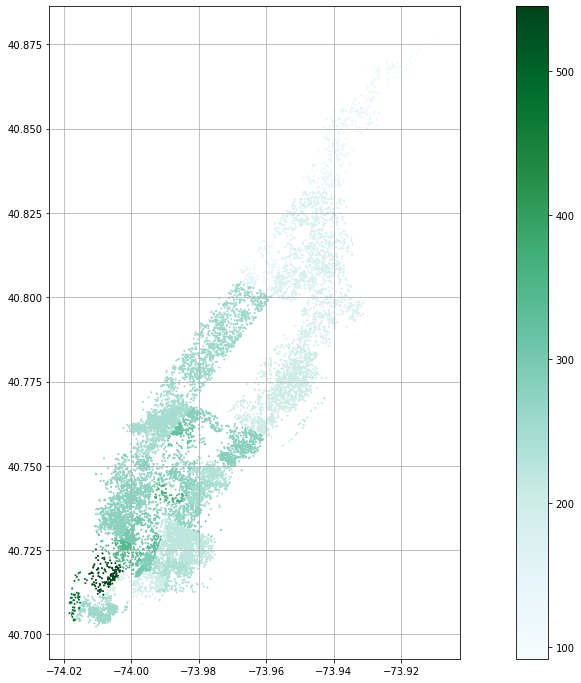

In [29]:
plt.figure()
mean_price_df.plot(figsize=(20, 12),
                  column='mean_neibhourhood_price',
                  markersize=1,
                  cmap='BuGn',
                  legend=True)
plt.grid()
plt.show()

## Get the neighbourhood polygons

In [30]:
nbhoods = geopandas.read_file('../data/raw/neighbourhoods.geojson')

In [31]:
nbhoods.head()

,neighbourhood,neighbourhood_group,geometry
0,Bayswater,Queens,"(POLYGON ((-73.76670799999999 40.614911, -73.768253 40.614878, -73.773977 40.616004, -73.77363099999999 40.616327, -73.76873500000001 40.620901, -73.767459 40.620511, -73.76697799999999 40.616919,..."
1,Allerton,Bronx,"(POLYGON ((-73.848597 40.87167, -73.845823 40.870239, -73.85455899999999 40.859954, -73.854665 40.859586, -73.85638899999999 40.857594, -73.868882 40.857223, -73.868318 40.857862, -73.869553999999..."
2,City Island,Bronx,"(POLYGON ((-73.782822 40.843919, -73.782572 40.843295, -73.782607 40.843286, -73.782785 40.843755, -73.783092 40.843685, -73.78287400000001 40.843124, -73.782901 40.843118, -73.78313300000001 40.8..."
3,Ditmars Steinway,Queens,"(POLYGON ((-73.90160299999999 40.76777, -73.90390600000001 40.76814, -73.904667 40.768545, -73.90560499999999 40.768717, -73.916607 40.770407, -73.91726199999999 40.770785, -73.92232300000001 40.7..."
4,Ozone Park,Queens,"(POLYGON ((-73.83754399999999 40.691364, -73.83108300000001 40.678151, -73.83087500000001 40.678109, -73.83094 40.67812, -73.83208 40.675261, -73.83305300000001 40.675412, -73.83375599999999 40.67..."


In [33]:
nbhoods.neighbourhood_group.value_counts()

Queens           55
Bronx            50
Staten Island    48
Brooklyn         48
Manhattan        32
Name: neighbourhood_group, dtype: int64

In [35]:
nbhoods = nbhoods[nbhoods.neighbourhood_group == 'Manhattan']

In [36]:
nbhoods.head()

,neighbourhood,neighbourhood_group,geometry
18,Battery Park City,Manhattan,"(POLYGON ((-74.01375400000001 40.71369, -74.014262 40.710928, -74.016542 40.704733, -74.01617400000001 40.702572, -74.01563 40.701862, -74.01512700000001 40.70139, -74.014008 40.701043, -74.013959..."
43,Chinatown,Manhattan,"(POLYGON ((-73.99999099999999 40.717977, -73.998636 40.717077, -73.99779100000001 40.716793, -73.996478 40.719048, -73.99480800000001 40.718457, -73.989155 40.716708, -73.9902 40.714665, -73.99012..."
52,Chelsea,Manhattan,"(POLYGON ((-73.993464 40.75219, -73.987937 40.749855, -73.987933 40.749853, -73.987973 40.749467, -73.991356 40.744763, -73.99421100000001 40.741013, -73.989777 40.739169, -73.990371 40.737098, -7..."
53,Civic Center,Manhattan,"(POLYGON ((-73.99799400000001 40.712722, -73.99777 40.711971, -74.002363 40.711591, -74.003337 40.711236, -74.003355 40.71123, -74.00366200000001 40.711487, -74.005358 40.712151, -74.005769 40.712..."
80,East Harlem,Manhattan,"(POLYGON ((-73.93383 40.819521, -73.93383 40.819521, -73.933829 40.815585, -73.93394499999999 40.815588, -73.93394499999999 40.815588, -73.93394600000001 40.815588, -73.934015 40.814484, -73.93385..."


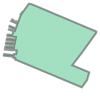

In [52]:
list(nbhoods[nbhoods.neighbourhood == 'Chelsea'].geometry)[0]

In [53]:
chelsea = list(nbhoods[nbhoods.neighbourhood == 'Chelsea'].geometry)[0]

## Get subway data

In [37]:
subway = geopandas.read_file('../data/raw/subway.geojson')

In [38]:
subway.head()

,name,url,line,objectid,notes,geometry
0,Astor Pl,http://web.mta.info/nyct/service/,4-6-6 Express,1,"4 nights, 6-all times, 6 Express-weekdays AM southbound, PM northbound",POINT (-73.99106999861966 40.73005400028978)
1,Canal St,http://web.mta.info/nyct/service/,4-6-6 Express,2,"4 nights, 6-all times, 6 Express-weekdays AM southbound, PM northbound",POINT (-74.00019299927328 40.71880300107709)
2,50th St,http://web.mta.info/nyct/service/,1-2,3,"1-all times, 2-nights",POINT (-73.98384899986625 40.76172799961419)
3,Bergen St,http://web.mta.info/nyct/service/,2-3-4,4,"4-nights, 3-all other times, 2-all times",POINT (-73.97499915116808 40.68086213682956)
4,Pennsylvania Ave,http://web.mta.info/nyct/service/,3-4,5,"4-nights, 3-all other times",POINT (-73.89488591154061 40.66471445143568)


In [40]:
subway.shape

(473, 6)

In [55]:
subway[subway.geometry.within(chelsea)]

,name,url,line,objectid,notes,geometry
95,23rd St,http://web.mta.info/nyct/service/,1-2,96,"1-all times, 2-nights",POINT (-73.99565700164869 40.74408099989751)
198,28th St,http://web.mta.info/nyct/service/,1-2,199,"1-all times, 2-nights",POINT (-73.99336500134324 40.74721499918219)
202,18th St,http://web.mta.info/nyct/service/,1-2,203,"1-all times, 2-nights",POINT (-73.99787100060406 40.7410399998021)
357,34th St - Penn Station,http://web.mta.info/nyct/service/,1-2-3,358,"1,2,3-all times",POINT (-73.99105699913983 40.75037300003949)
364,23rd St,http://web.mta.info/nyct/service/,F-M,365,"F-all times, M-weekdays and evenings",POINT (-73.99276500471389 40.742954317826)
435,23rd St,http://web.mta.info/nyct/service/,A-C-E,436,"A-nights, C-all other times, E-all times",POINT (-73.99804100117201 40.74590599939995)
440,14th St,http://web.mta.info/nyct/service/,F-M,441,"F-all times, M-weekdays and evenings",POINT (-73.99620899921355 40.73822799969515)
443,14th St,http://web.mta.info/nyct/service/,A-C-E,444,"A,E-all times, C-all times exc nights",POINT (-74.00168999937027 40.7408930001933)
469,34th St - Hudson Yards,http://web.mta.info/nyct/service/,7-7 Express,470,"7-all times, 7 Express-rush hours AM westbound, PM eastbound",POINT (-74.00219709442206 40.75544635961596)


In [63]:
subway_chelsea = subway[subway.geometry.within(chelsea)]

In [64]:
subway_chelsea.name.str.contains("Penn")

95     False
198    False
202    False
357     True
364    False
435    False
440    False
443    False
469    False
Name: name, dtype: bool

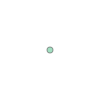

In [71]:
list(subway_chelsea[subway_chelsea.name.str.contains("Penn")].geometry)[0]

In [72]:
penn_station_nyc = list(subway_chelsea[subway_chelsea.name.str.contains("Penn")].geometry)[0]

In [39]:
type(subway.geometry)

geopandas.geoseries.GeoSeries

## Now get all airbnb's in Chelsea

In [56]:
#chelsea_airbnb
mean_price_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 13054 entries, 0 to 27439
Data columns (total 5 columns):
price                      13054 non-null int64
neighbourhood              13054 non-null object
neighbourhood_group        13054 non-null object
geometry                   13054 non-null object
mean_neibhourhood_price    13054 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 611.9+ KB


In [57]:
mean_price_df.shape

(13054, 5)

In [58]:
chelsea_airbnb_df = mean_price_df[mean_price_df.neighbourhood == "Chelsea"]

In [59]:
chelsea_airbnb_df.shape

(819, 5)

In [60]:
chelsea_airbnb_df.head()

,price,neighbourhood,neighbourhood_group,geometry,mean_neibhourhood_price
60,375,Chelsea,Manhattan,POINT (-73.9953 40.74623),277.509158
187,125,Chelsea,Manhattan,POINT (-73.99999 40.74031),277.509158
249,205,Chelsea,Manhattan,POINT (-73.99566999999999 40.74238),277.509158
353,130,Chelsea,Manhattan,POINT (-73.99544 40.74893),277.509158
359,279,Chelsea,Manhattan,POINT (-74.00123000000001 40.7395),277.509158


In [62]:
chelsea_airbnb_df.geometry.within(chelsea).sum()

818

In [87]:
(chelsea_airbnb_df.distance(penn_station_nyc) < 0.01).sum()

321

In [88]:
chelsea_airbnb_df.distance(penn_station_nyc)

60       0.005930
187      0.013456
249      0.009229
353      0.004614
359      0.014890
           ...   
48658    0.008817
48816    0.012477
48835    0.009253
48838    0.007835
48851    0.007937
Length: 819, dtype: float64

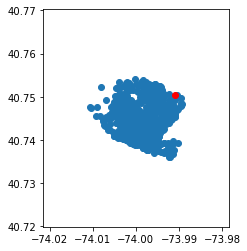

In [90]:
ax = chelsea_airbnb_df.plot()
geopandas.GeoSeries([penn_station_nyc]).plot(ax=ax, color='red')
plt.show()

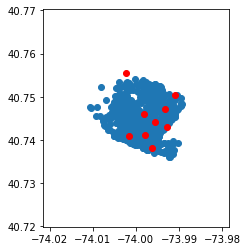

In [91]:
ax = chelsea_airbnb_df.plot()
subway_chelsea.plot(ax=ax, color='red')
plt.show()